Soporte respiratorio
===

* 41:42 min | Última modificación: Mayo 27, 2021 | [YouTube]

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Definición del problema

La decisión de cuando un paciente con soporte respiratorio puede respirar por sus propios medios fue un problema muy importante en la década de los 90. En este caso se desea construir un modelo de redes neuronales que permita pronósticar cuando se puede retirar el soporte mecanico. Se tiene un dataframe con las siguientes columnas:

* NIF: negative inspiratory pressure (cm. H20).

* VT: tidal volume.

* RR: respiratory rate (breaths/minute).

* Result: success/failure

Los primeros 21 patrones son usados para entrenamiento y los restantes para validación.

In [2]:
import pandas as pd


df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/weaning.csv",
    sep = ',',         # separador de campos
    thousands = None,  # separador de miles para números
    decimal = '.')     # separador de los decimales para números

df.head()

NIF   VT  RR   RESULT
0  -24  300  24  success
1  -30  500  17  failure
2  -23  300  29  success
3  -26  265  44  failure
4  -18  370  32  failure

In [3]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder().fit(df.RESULT)
df["RESULT"] = encoder.transform(df.RESULT)

## Análisis Exploratorio

In [4]:
df.describe()

NIF          VT         RR     RESULT
count  30.000000   30.000000  30.000000  30.000000
mean  -29.900000  439.433333  27.900000   0.500000
std    12.340989  200.239285   8.470435   0.508548
min   -60.000000  124.000000  13.000000   0.000000
25%   -40.000000  300.000000  22.250000   0.000000
50%   -28.000000  400.000000  27.500000   0.500000
75%   -22.000000  522.500000  32.000000   1.000000
max   -10.000000  950.000000  46.000000   1.000000

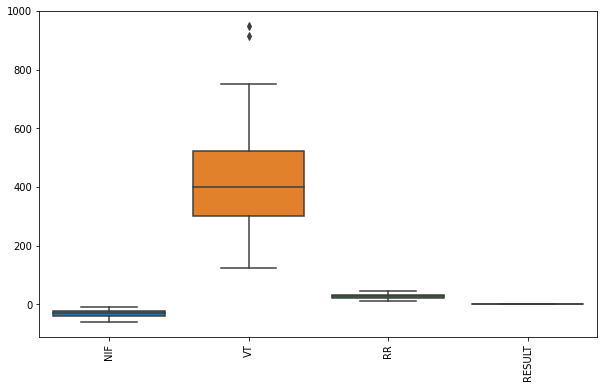

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

#
# Los rangos de las variables numéricas son
# bastantes diferentes
#
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90);

In [6]:
from sklearn.preprocessing import MinMaxScaler

#
#  Se escalan todas las variables al rango [0, 1]
#  para evitar problemas asociados a la escala
#
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.head()

NIF        VT        RR  RESULT
0  0.72  0.213075  0.333333     1.0
1  0.60  0.455206  0.121212     0.0
2  0.74  0.213075  0.484848     1.0
3  0.68  0.170702  0.939394     0.0
4  0.84  0.297821  0.575758     0.0

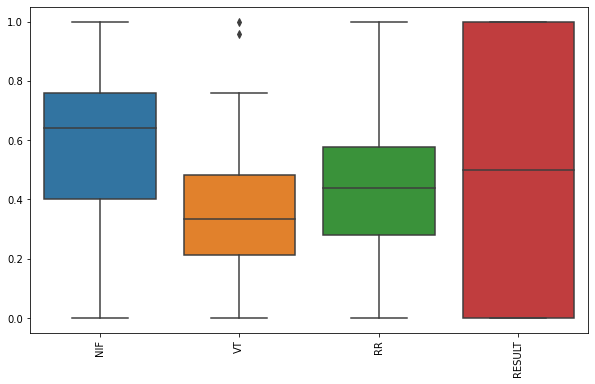

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_norm)
plt.xticks(rotation=90);

## Desarrollo y evaluación del modelo

In [8]:
#
# Crea el modelo con una capa oculta
#
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


parameters = [
    {
        "hidden_layer_sizes": [(h,) for h in range(10)],
        "learning_rate_init": [
            0.01,
            0.05,
            0.10,
            0.15,
            0.20,
            0.25,
            0.30,
        ],
        "momentum": [
            0.60,
            0.70,
            0.80,
            0.90,
        ],
    },
]

m = GridSearchCV(
    MLPClassifier(
        activation="logistic",
        learning_rate="adaptive",
        max_iter=2000,
    ),
    parameters,
    cv=10,
    verbose=0,
)

m.fit(df_norm[['NIF', 'VT', 'RR']][:21], df_norm.RESULT[:21])

m.best_estimator_

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1,), learning_rate='adaptive',
              learning_rate_init=0.1, max_fun=15000, max_iter=2000,
              momentum=0.7, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [9]:
#
# Pronostico
#
df_norm["RESULT_pred"] = m.predict(df_norm[['NIF', 'VT', 'RR']])

confusion_matrix(
    y_true=df_norm.RESULT[:21],
    y_pred=df_norm.RESULT_pred[:21],
)

array([[11,  1],
       [ 0,  9]])

In [10]:
confusion_matrix(
    y_true=df_norm.RESULT[21:],
    y_pred=df_norm.RESULT_pred[21:],
)

array([[2, 1],
       [0, 6]])